<h1>Variational Autoencoder Tutorial</h1>

By [Tianran Chen](https://scholar.google.com/citations?hl=en&authuser=1&user=OHWhO7gAAAAJ) and [Emmit Phalen](https://www.linkedin.com/in/emmit-phalen)


---
[Open in Collab](https://colab.research.google.com/drive/1OS62dsaQRVP4fpixzeElfEwFkki8uCsg?usp=sharing)

Collab link QR Code:

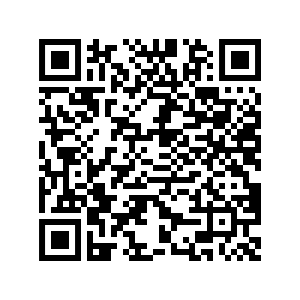

#Data Preparation

**Imports and Setup**



In [1]:
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt;
from IPython import display
plt.rcParams['figure.dpi'] = 100

# Set the device to "cpu" if running on CPU, otherwise set to "cuda" for GPU
device = "cpu"
#device = "cuda"

# Set up original data size and font size for plots
Hsize,Ksize,Lsize = [4, 191, 191]
FS = 10

def reflect(S0):
    """
    Reflect the data to create symmetry.

    Parameters:
    S0 (ndarray): Input array to reflect.

    Returns:
    ndarray: Symmetrically reflected array.
    """
    S0_slice = S0[1:, :]
    S0_reflected = np.concatenate((np.flipud(S0_slice), S0), axis=0)
    S0_reflected = np.concatenate((np.fliplr(S0_reflected[:, 1:]), S0_reflected), axis=1)
    return S0_reflected

**Download Data from Google Drive**




In [2]:
import gdown
url='https://drive.google.com/file/d/1hAA1ExxlEgW3PhAl8fkX_YygZT-a1aba/view?usp=drive_link'
gdown.download(url, quiet=True, fuzzy=True, output="data.jld2")
print("Data downloaded!")

Data downloaded!


**Load Data**

In [3]:
data_original=h5py.File("./data.jld2","r")
data_dsfs=data_original["dsf"][:]    #load dynamic structure factors
N_samples=len(data_dsfs)
print(f"Number of samples: {N_samples}")

Number of samples: 4106


Define function to plot the DSF data and histogram


In [4]:
def plotHist(num, normfact=0):
    """
    Plot the histogram and image of the dynamic structure factor (DSF) data.

    Parameters:
    num (int): Sample index to plot.
    normfact (float): Normalization factor for tanh function. Default is 0 (no normalization).
    """
    plt.figure(figsize=(15, 4))

    # Retrieve and optionally normalize the data
    dat = data_dsfs[num]
    if normfact > 0:
        dat = np.tanh(dat * normfact/np.mean(dat))

    # Reshape the data
    datTemp = np.reshape(dat, (Lsize, Ksize, 4))

    # Setup subplots
    ax1 = plt.subplot2grid(shape=(1, 5), loc=(0, 0), colspan=4)
    ax2 = plt.subplot2grid(shape=(1, 5), loc=(0, 4), colspan=1)

    # Reflect the data to create symmetry and combine
    datCombine = []
    for idx in range(4):
        if idx == 0:
            datCombine = reflect(datTemp[:, :, idx])
        else:
            datCombine = np.append(datCombine, reflect(datTemp[:, :, idx]), axis=0)

    # Plot the combined data as an image
    ax1.imshow(datCombine.T)

    # Plot the histogram of the combined data
    ax2.hist(np.reshape(datCombine, -1))

    # Add a title
    title = f"Sample Index: {num}"
    if normfact > 0:
        title += f", normFactor: {normfact}"
    plt.suptitle(title, fontsize=24)

    # Set x-ticks for the image plot
    xtick_locs = [0, list(datCombine.shape)[0] // 4, list(datCombine.shape)[0] * (4 / 8), list(datCombine.shape)[0] * (6 / 8), list(datCombine.shape)[0] - 1]
    xtick_labels = [-20, -20, -20, -20, 20]
    ax1.set_xticks(xtick_locs, xtick_labels, fontsize=FS)
    ax1.set_xticks([list(datCombine.shape)[0] // 8, list(datCombine.shape)[0] * (3 / 8), list(datCombine.shape)[0] * (5 / 8), list(datCombine.shape)[0] * (7 / 8)], [0, 0, 0, 0], fontsize=FS, minor=True)
    ax1.grid(axis='x', which="major", color="black")

    # Set y-ticks for the image plot
    ax1.set_yticks([0, list(datCombine.shape)[1] // 2], [20, 0], fontsize=FS)

    # Add secondary x-axis with custom labels
    labels = [f"L in [{i}.25, K, L] (r.l.u)" for i in range(4)]
    sec = ax1.secondary_xaxis(location=0)
    sec.set_xticks([list(datCombine.shape)[0] // 8, list(datCombine.shape)[0] * (3 / 8), list(datCombine.shape)[0] * (5 / 8), list(datCombine.shape)[0] * (7 / 8)], labels=labels)
    sec.tick_params('x', length=40, width=0)
    sec.set_xticklabels(labels, fontsize=FS)

    # Set y-axis label
    ax1.set_ylabel("K (r.l.u)", fontsize=FS)

    plt.tight_layout()
    plt.show()

**Plot Original Data**\
The following plots display random samples from the original dataset. These visualizations help to understand the distribution and skewness of the data in its raw form.


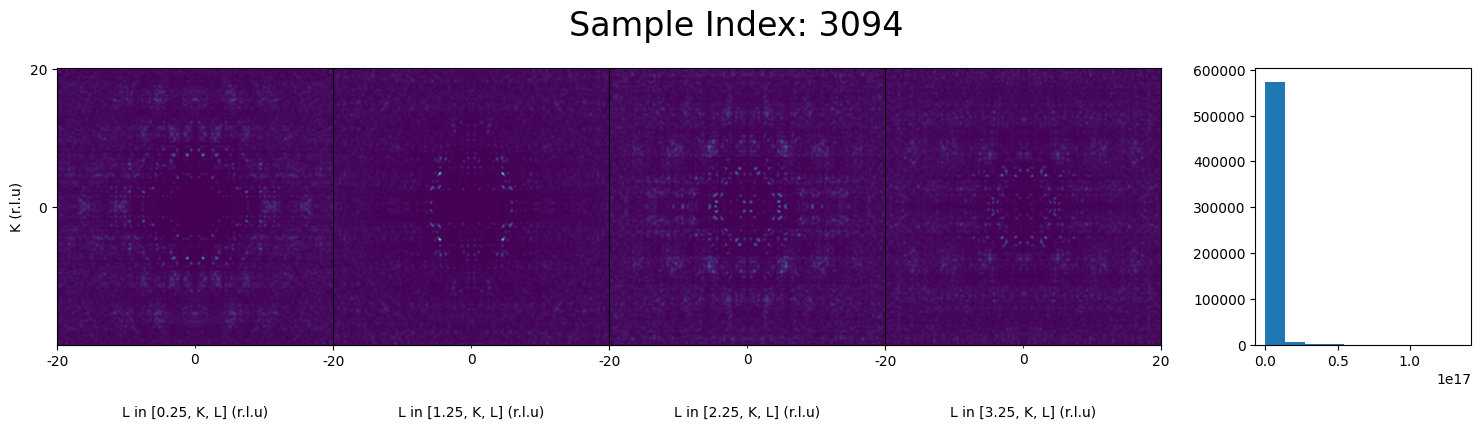

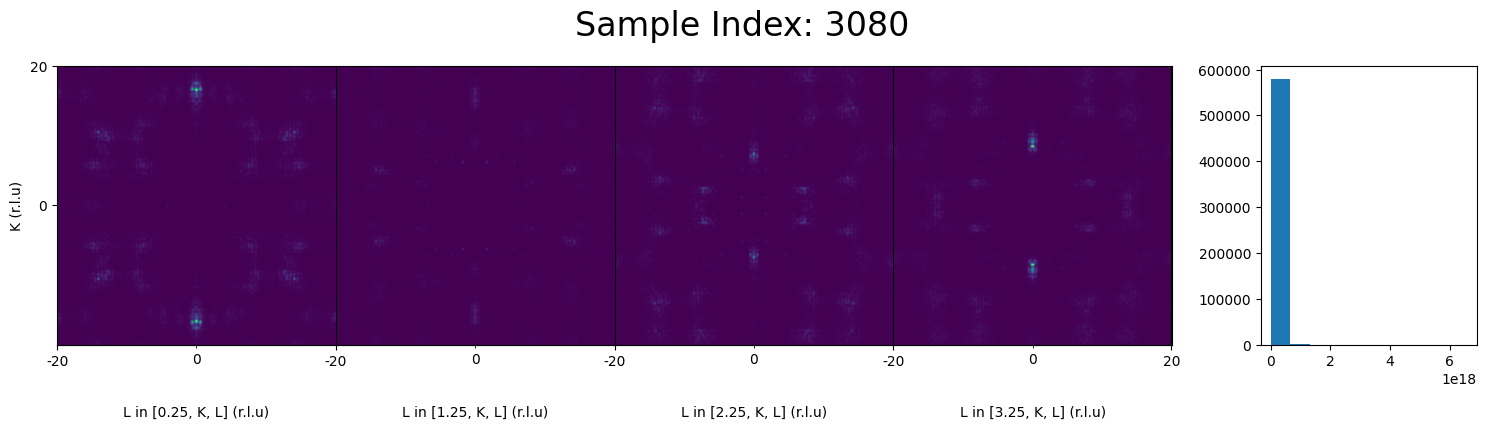

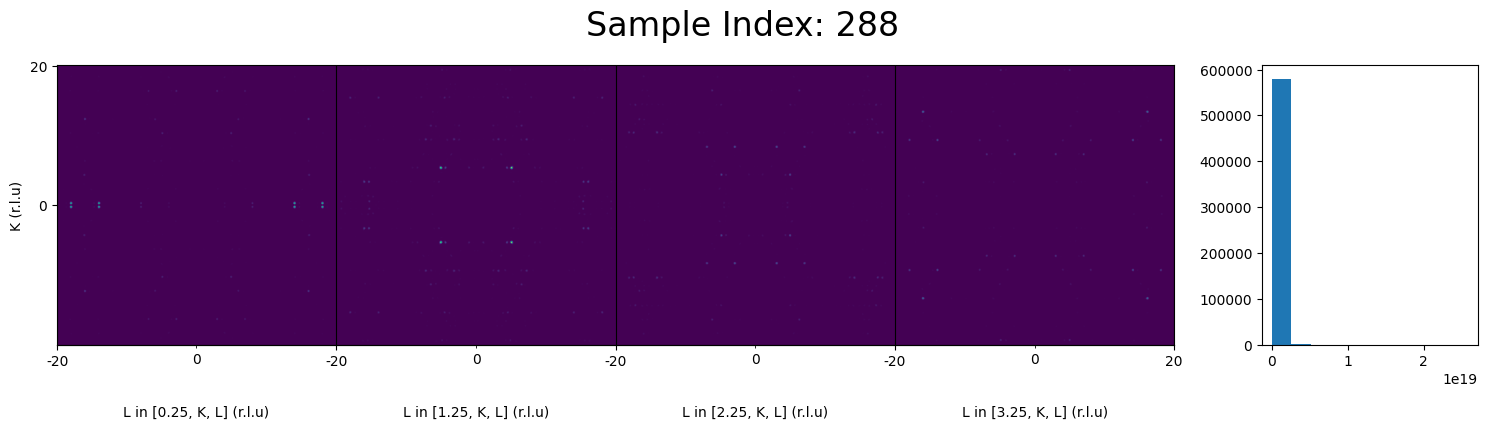

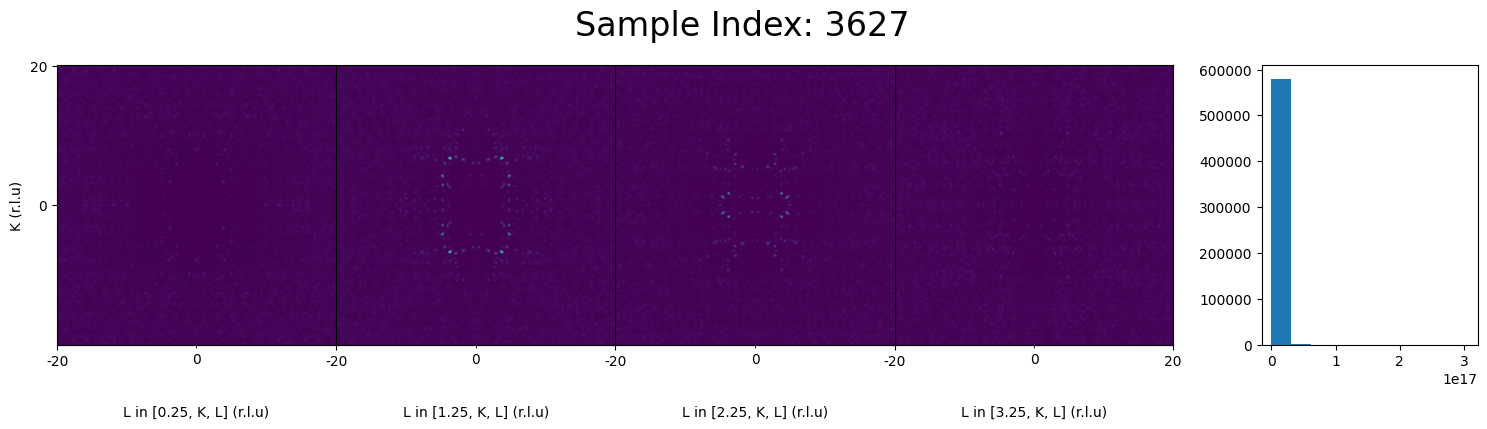

In [5]:
# Display a random sample and its histogram
for i in range(4):
  plotHist(np.random.randint(N_samples),0)

**Skewness is the degree of asymmetry observed in a probability distribution.** \
Skewness: https://www.geeksforgeeks.org/skewness-measures-and-interpretation/

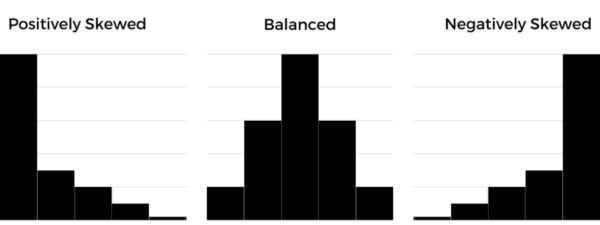



**Data Normalization**

Data are normalized using:
$\tanh(\frac{X}{\bar{X}}\cdot \text{normFactor})$

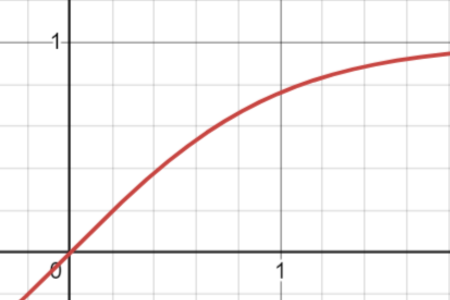
---



**Display Normalization Effect**\
The following plots display a specific sample with different normalization factors using the tanh function. This demonstrates the effect of normalization on the dynamic structure factors.


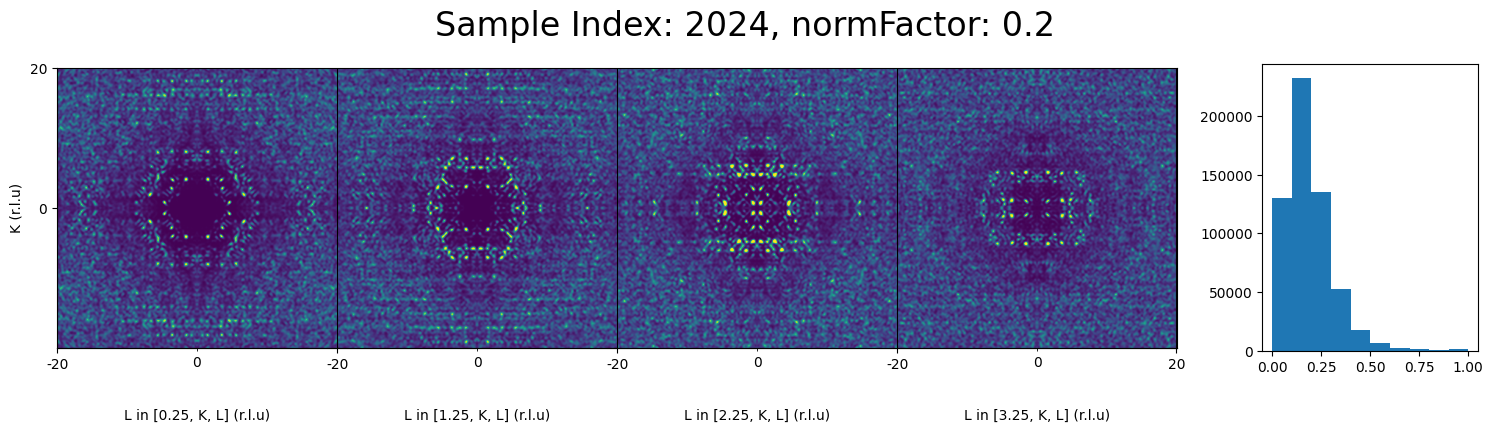

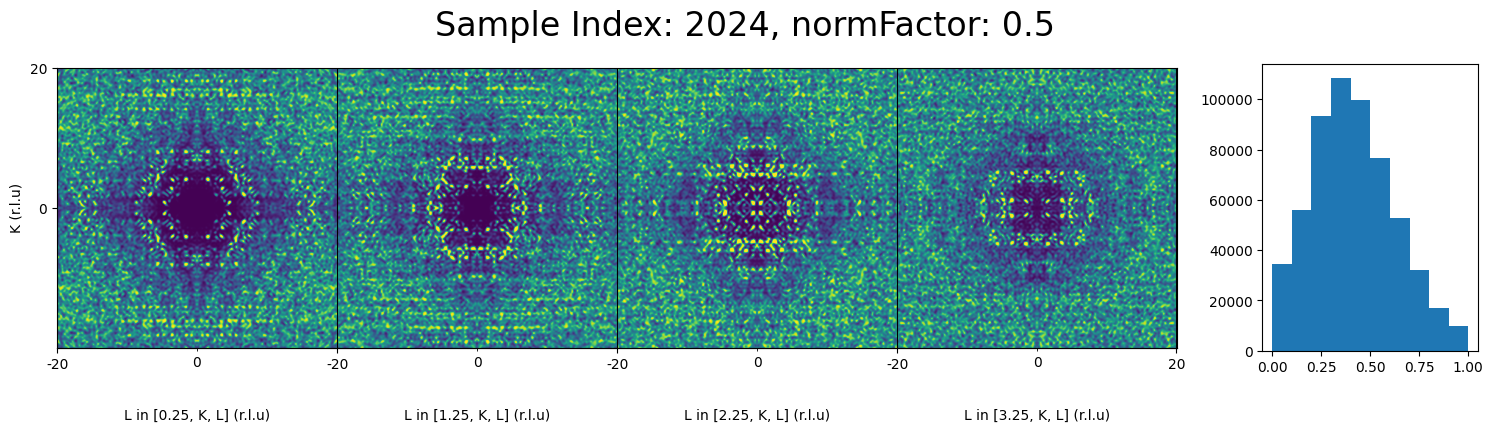

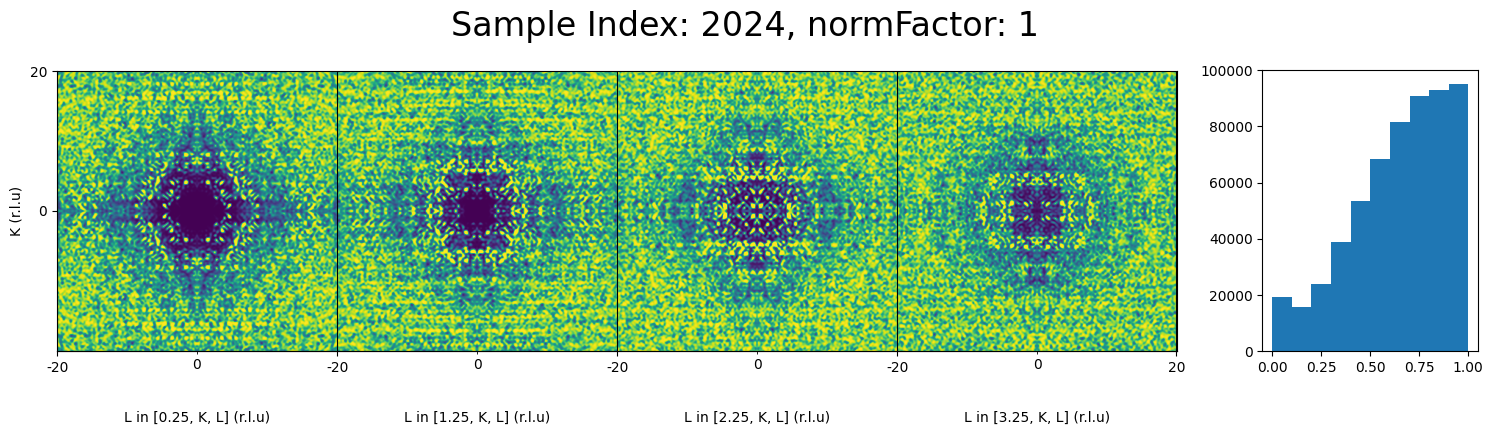

In [6]:
# Display a sample with different normalization factors
normFactors=[0.2,0.5,1]
idx=2024
for normFactor in normFactors:
  plotHist(idx,normFactor)

**Select your Normalization Factor**

In [10]:
normFactor=0.5
print("Normalization factor:",normFactor)

Normalization factor: 0.5


**Pooling Function**


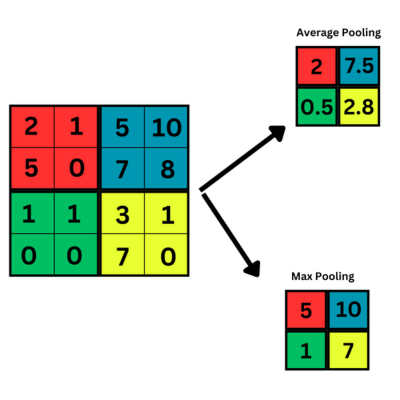

More info here: https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html,
https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html



Define functions for pooling and visualization

In [11]:
# Function to apply pooling to data
def pooling(data, kernel, pool_type="avg"):
    """
    Apply pooling to the input data.

    Parameters:
    data (Tensor): Input tensor to pool.
    kernel (int): Kernel size for pooling.
    pool_type (str): Type of pooling - "avg" for Average Pooling or "max" for Max Pooling.

    Returns:
    Tensor: Pooled data.
    """
    if pool_type == "avg":
        pool = nn.AvgPool2d(kernel_size=kernel)
    else:
        pool = nn.MaxPool2d(kernel_size=kernel)
    pooled_data = pool(data)
    return pooled_data

# Function to display the effect of pooling
def displayPooling(num, kernelsize=1):
    """
    Display the effect of pooling on a sample from the dataset.

    Parameters:
    num (int): Sample index to display.
    kernelsize (int): Kernel size for pooling. Default is 1.
    """
    plt.figure(figsize=(12, 3))
    dat = data_dsfs[num]

    # Normalize the data using tanh function
    dat = np.tanh(dat / np.mean(dat) * normFactor)
    dat = torch.from_numpy(dat).detach().to("cpu")
    dat = np.reshape(dat, (Lsize, Ksize, 4))

    # Combine the data after applying pooling
    datCombine = []
    for idx in range(4):
        datTemp = dat.permute(*torch.arange(dat.ndim - 1, -1, -1))
        datTemp = pooling(datTemp, kernelsize, "avg")  # Apply pooling (change to "max" for Max Pooling)
        datTemp = datTemp.permute(*torch.arange(datTemp.ndim - 1, -1, -1))

        if idx == 0:
            datCombine = reflect(datTemp[:, :, idx])
        else:
            datCombine = np.append(datCombine, reflect(datTemp[:, :, idx]), axis=0)

    # Plot the pooled data
    plt.title(f"Kernel Size: {kernelsize}, Pixels: {datCombine.size}", fontsize=FS)
    plt.imshow(datCombine.T)
    plt.xticks([0, datCombine.shape[0] // 4, datCombine.shape[0] * 4 // 8, datCombine.shape[0] * 6 // 8, datCombine.shape[0] - 1],
               [-20, -20, -20, -20, 20], fontsize=FS)
    plt.xticks([datCombine.shape[0] // 8, datCombine.shape[0] * 3 // 8, datCombine.shape[0] * 5 // 8, datCombine.shape[0] * 7 // 8],
               [0, 0, 0, 0], fontsize=FS, minor=True)

    ax = plt.gca()
    ax.grid(axis='x', which="major", color="black")
    plt.yticks([0, datCombine.shape[1] // 2], [20, 0], fontsize=FS)

    # Add secondary x-axis with custom labels
    labels = [f"L in [{i}.25, K, L] (r.l.u)" for i in range(4)]
    sec = ax.secondary_xaxis(location=0)
    sec.set_xticks([datCombine.shape[0] // 8, datCombine.shape[0] * 3 // 8, datCombine.shape[0] * 5 // 8, datCombine.shape[0] * 7 // 8],
                   labels=labels)
    sec.tick_params('x', length=40, width=0)
    sec.set_xticklabels(labels, fontsize=FS)

    plt.ylabel("K (r.l.u)", fontsize=FS)
    plt.tight_layout()
    plt.show()

**Display Pooling Effect**\
The following plots demonstrate the effect of different kernel sizes on pooling. Pooling compresses the data by summarizing regions to reduce the data size.


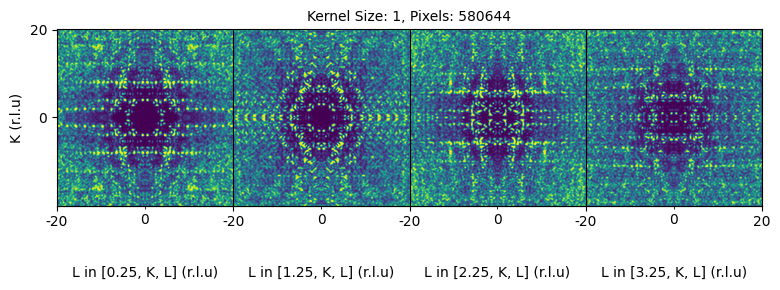

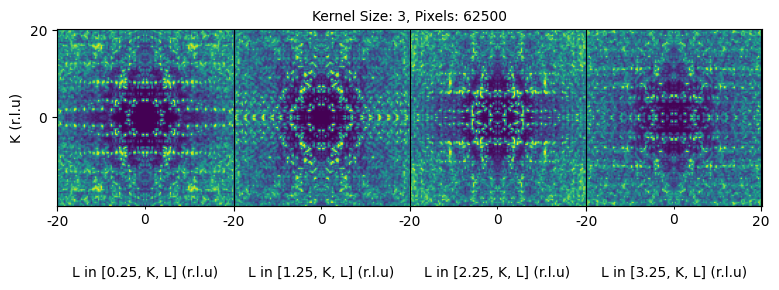

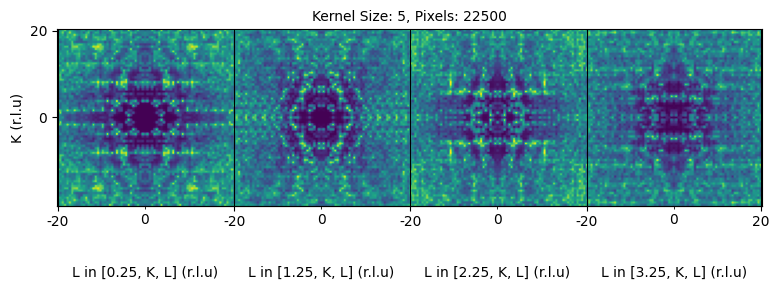

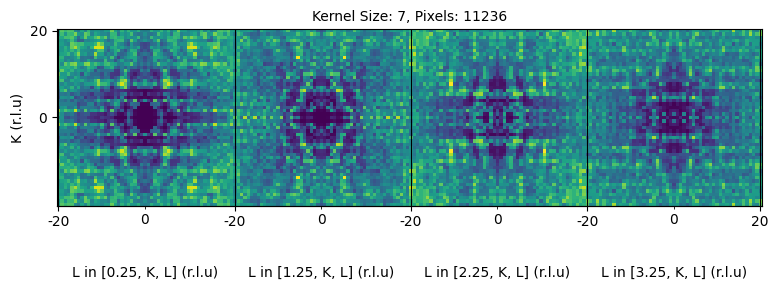

In [12]:
# Demonstrate the effect of pooling with different kernel sizes
for i in range(4):
  displayPooling(901,i*2+1)

**Select your Pooling Type and Kernel Size**



In [13]:
pooling_type = "avg"    # Pooling type: "avg" for Average Pooling, or "max" for Max Pooling
kernel_size = 3
print(f"Pooling Type: {pooling_type}")
print(f"Kernel Size: {kernel_size}")

Pooling Type: avg
Kernel Size: 3


**Load Data for Training**\
Typically, the data should be split into training, testing, and validation sets. However, for simplicity, we use a single set for all purposes here.

In [14]:
# Batch size for data loader
Bsize = 64

# Initialize normalized data array
normdata_dsfs = np.zeros((len(data_dsfs), (Ksize // kernel_size) ** 2 * 4))

for i in range(len(data_dsfs)):
    dat = 1 * data_dsfs[i, :]
    dat = np.tanh(dat / np.mean(dat) * normFactor)          # apply normalization
    dat = np.reshape(dat, (Lsize, Ksize, 4))
    dat = torch.from_numpy(dat)
    dat = dat.permute(*torch.arange(dat.ndim - 1, -1, -1))
    dat = pooling(dat, kernel_size, pooling_type)           # apply pooling
    dat = dat.permute(*torch.arange(dat.ndim - 1, -1, -1))
    dat = np.reshape(dat, -1)
    normdata_dsfs[i, :] = dat

# Create a DataLoader for the normalized data
data_all = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(normdata_dsfs, dtype=torch.float32),            # dynamic structure factor
        torch.tensor(data_original["msd"][:], dtype=torch.float32),  # root-mean square displacement
        torch.tensor(data_original["ptype"][:], dtype=torch.float32)),# phonon type
    batch_size=Bsize, shuffle=True)

#Variational Autoencoder (VAE)

**Define VAE Model and Training Function**

Here we use fully connected layers


In [15]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, input_dims=[Hsize,(Ksize//kernel_size),(Lsize//kernel_size)],
                 hidden_dims=[512,128,32], lat_dim=8):
        super(VAE, self).__init__()
        encoders=[
            nn.Linear(input_dims[0]*input_dims[1]*input_dims[2], hidden_dims[0]),
            nn.ReLU()]
        decoders=[nn.ReLU()]

        for i in range(np.size(hidden_dims)-1):
            encoders.append(nn.Linear(hidden_dims[i],hidden_dims[i+1]))
            encoders.append(nn.ReLU())
            decoders.append(nn.Linear(hidden_dims[-1-i],hidden_dims[-2-i]))
            decoders.append(nn.ReLU())

        decoders.append(nn.Linear(hidden_dims[0],input_dims[0]*input_dims[1]*input_dims[2]))
        decoders.append(nn.Sigmoid())

        self.encoder = nn.Sequential(*encoders)
        self.decoder = nn.Sequential(*decoders)

        self.fc1 = nn.Linear(hidden_dims[-1], lat_dim)
        self.fc2 = nn.Linear(hidden_dims[-1], lat_dim)
        self.fc3 = nn.Linear(lat_dim, hidden_dims[-1])

    def generate(self,mu):
        z = self.fc3(mu)
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().to(device)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar

def loss_fn(recon_x, x, mu, logvar):
    MSE =  ((x - recon_x)**2).sum() * kernel_size**2            # Reconstruction Loss (Mean Square Error)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())  # KL Divergence Loss
    return MSE, KLD

import copy
import time

# Define the training function
def train_vae(model, optimizer, data, epochs, beta, learning_rate):
    for g in optimizer.param_groups:
        g['lr'] = learning_rate

    losses = np.empty((3, epochs))
    losses[:, 1:] = np.nan
    np.set_printoptions(suppress=True)

    # Set up plots
    fig = plt.figure(figsize=(8, 2))
    total_plot = fig.add_subplot(1, 3, 1)
    mse_plot = fig.add_subplot(1, 3, 2)
    KL_plot = fig.add_subplot(1, 3, 3)
    plots = [total_plot, mse_plot, KL_plot]
    x_plot = []
    y_plot = []

    for epoch in range(epochs):
        batchloss = torch.tensor(losses[:, 0], dtype=torch.float32)
        for x_input, y, z in data:
            x_input = x_input[0].to(device)
            optimizer.zero_grad()
            x_output, mu, logvar = model(x_input)
            mse, kld = loss_fn(x_output, x_input, mu, logvar)
            kld *= beta
            loss = mse + kld
            batchloss += torch.tensor([loss, mse, kld])
            loss = loss / x_input.shape[0]
            loss.backward()
            optimizer.step()

        losses[:, epoch] = (batchloss / len(data.dataset)).detach().to('cpu').numpy()

        # Plot loss
        x_plot.append(epoch + 1)
        y_plot.append(losses[:, epoch])

        titles = ["Total Loss", "Recon Loss", "KL Divergence"]

        for i in range(3):
            # Plot losses
            plots[i].plot(x_plot, [n[i] for n in y_plot], linewidth=1, color='red')
            plots[i].set_xlim(min(x_plot), max(x_plot))
            plots[i].set_ylim(min([n[i] for n in y_plot]), max([n[i] for n in y_plot]))
            plots[i].set_xlabel(f"Epoch: {x_plot[-1]}", fontsize=6)
            plots[i].title.set_text(f"{titles[i]}: {[n[i] for n in y_plot][-1]:.3f}")
            plots[i].xaxis.set_tick_params(labelsize=6)
            plots[i].yaxis.set_tick_params(labelsize=6)

        display.display(plt.gcf())
        time.sleep(0.01)
        display.clear_output(wait=True)

**Input your Selection of Hidden Layer Dimensions and Latent Dimensions**

Conventionally use powers of 2


In [16]:
hidden_dims = [512, 128, 32]
lat_dim = 8

print(f"Hidden layer dimensions: {hidden_dims}")
print(f"Latent dimension: {lat_dim}")

Hidden layer dimensions: [512, 128, 32]
Latent dimension: 8


**Initialize your VAE Model and Display Model Architechture**

In [17]:
# Initialize the VAE model
autoencoder = VAE(hidden_dims=hidden_dims, lat_dim=lat_dim)

# Move the model to the specified device (CPU or GPU)
autoencoder = autoencoder.to(device)

# Initialize the Adam optimizer with the parameters of the autoencoder
# For more details, refer to the Adam optimizer paper: https://arxiv.org/abs/1412.6980
opt = torch.optim.Adam(autoencoder.parameters(), betas=(0.9, 0.99))

# Display the model architecture
autoencoder

# If you encounter an error regarding the NVIDIA driver, please refer to the first cell under the imports section.
# Hyperparameter tuning tip: Try experimenting with the shape of the hidden dimensions (hidden_dims)
# or the number of latent dimensions (lat_dim) to see how they affect the model's performance.

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=15876, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=15876, bias=True)
    (6): Sigmoid()
  )
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=32, bias=True)
)

**Train the VAE**

Set the key hyperparameters before training:

epochs: Number of training cycles. More epochs can improve learning but increase training time.\
beta: Weight for the KL divergence term. Balances reconstruction loss and regularization.\
learning_rate: Step size for the optimizer. Smaller values allow finer adjustments but slow down training.

The following plots show total Loss, reconstruction loss, and
KL Divergence.\
You can stop and resume training anytime by clicking the "Stop/Run" button.

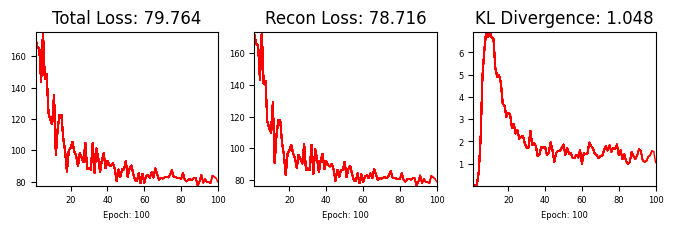

In [18]:
# Hyperparameters
epochs = 100
beta = 10.0
learning_rate = 1e-5

# Train the model
train_vae(autoencoder, opt, data_all, epochs, beta, learning_rate)

**Save and Load the Autoencoder State**

In [19]:
# Save the autoencoder state
# Remember to save the file locally or to your drive if you want to keep it
# This storage is lost when the session resets

filename='VAE_state'+str(hidden_dims)+str(lat_dim)+'.pt'
state={'state_dict':autoencoder.state_dict(),
      'optimizer':opt.state_dict()}

torch.save(state,filename)
print(f"Model saved as {filename}")

Model saved as VAE_state[512, 128, 32]8.pt


In [29]:
# Initialize your model and optimizer
autoencoder = VAE(hidden_dims=hidden_dims, lat_dim=lat_dim)
opt = torch.optim.Adam(autoencoder.parameters(), betas=(0.9, 0.99))

# Load the saved state
filename='VAE_state'+str(hidden_dims)+str(lat_dim)+'.pt'
checkpoint = torch.load(filename)

# Load state dictionaries
autoencoder.load_state_dict(checkpoint['state_dict'])
opt.load_state_dict(checkpoint['optimizer'])
autoencoder.to(device)
print("Model and optimizer state loaded.")

Model and optimizer state loaded.


#Display Results

Define function to visualize reconstructed data

In [21]:
def displayRecon(num):
    plt.figure(figsize=(18, 6))

    # Get data and run through autoencoder
    dat = data_all.dataset.tensors[0][num].to(device)
    recon, lat, _ = autoencoder(dat)

    # Detach and move to CPU for processing
    dat = dat.detach().cpu()
    recon = recon.detach().cpu()
    lat = lat.detach().cpu()

    # Reshape data
    dat = np.reshape(dat, (Ksize // kernel_size, Lsize // kernel_size, 4))
    recon = np.reshape(recon, (Ksize // kernel_size, Lsize // kernel_size, 4))

    datCombine = []
    datCombine2 = []

    # Reflect data and reconstructed data
    for idx in range(4):
        if idx == 0:
            datCombine = reflect(dat[:, :, idx])
            datCombine2 = reflect(recon[:, :, idx])
        else:
            datCombine = np.append(datCombine, reflect(dat[:, :, idx]), axis=0)
            datCombine2 = np.append(datCombine2, reflect(recon[:, :, idx]), axis=0)

    # Plot input data
    plt.suptitle(f"Sample Index: {num}")
    ax1 = plt.subplot(2, 1, 1)
    ax1.set_title("Input Data", fontsize=10)
    ax1.imshow(datCombine.T)
    ax1.set_xticks([0, datCombine.shape[0] // 4, datCombine.shape[0] // 2, datCombine.shape[0] * 3 // 4, datCombine.shape[0] - 1], [-20, -20, -20, -20, 20], fontsize=FS)
    ax1.set_xticks([datCombine.shape[0] // 8, datCombine.shape[0] * 3 // 8, datCombine.shape[0] * 5 // 8, datCombine.shape[0] * 7 // 8], [0, 0, 0, 0], fontsize=FS, minor=True)
    ax1.grid(axis='x', which='major', color='black')
    ax1.set_yticks([0, datCombine.shape[1] // 2], [20, 0], fontsize=FS)

    labels = [f"L in [{i}.25, K, L] (r.l.u)" for i in range(4)]
    sec = ax1.secondary_xaxis(location=0)
    sec.set_xticks([datCombine.shape[0] // 8, datCombine.shape[0] * 3 // 8, datCombine.shape[0] * 5 // 8, datCombine.shape[0] * 7 // 8], labels=labels)
    sec.tick_params('x', length=40, width=0)
    sec.set_xticklabels(labels, fontsize=FS)
    ax1.set_ylabel("K (r.l.u)", fontsize=FS)

    # Plot reconstructed data
    ax2 = plt.subplot(2, 1, 2)
    ax2.set_title("Reconstructed Data", fontsize=10)
    ax2.imshow(datCombine2.T)
    ax2.set_xticks([0, datCombine.shape[0] // 4, datCombine.shape[0] // 2, datCombine.shape[0] * 3 // 4, datCombine.shape[0] - 1], [-20, -20, -20, -20, 20], fontsize=FS)
    ax2.set_xticks([datCombine.shape[0] // 8, datCombine.shape[0] * 3 // 8, datCombine.shape[0] * 5 // 8, datCombine.shape[0] * 7 // 8], [0, 0, 0, 0], fontsize=FS, minor=True)
    ax2.grid(axis='x', which='major', color='black')
    ax2.set_yticks([0, datCombine.shape[1] // 2], [20, 0], fontsize=FS)

    sec = ax2.secondary_xaxis(location=0)
    sec.set_xticks([datCombine.shape[0] // 8, datCombine.shape[0] * 3 // 8, datCombine.shape[0] * 5 // 8, datCombine.shape[0] * 7 // 8], labels=labels)
    sec.tick_params('x', length=40, width=0)
    sec.set_xticklabels(labels, fontsize=FS)
    ax2.set_ylabel("K (r.l.u)", fontsize=FS)

    plt.tight_layout()


**Compare Input and Reconstructed Data**

The following plots display the input and reconstruction of specific samples for comparison.


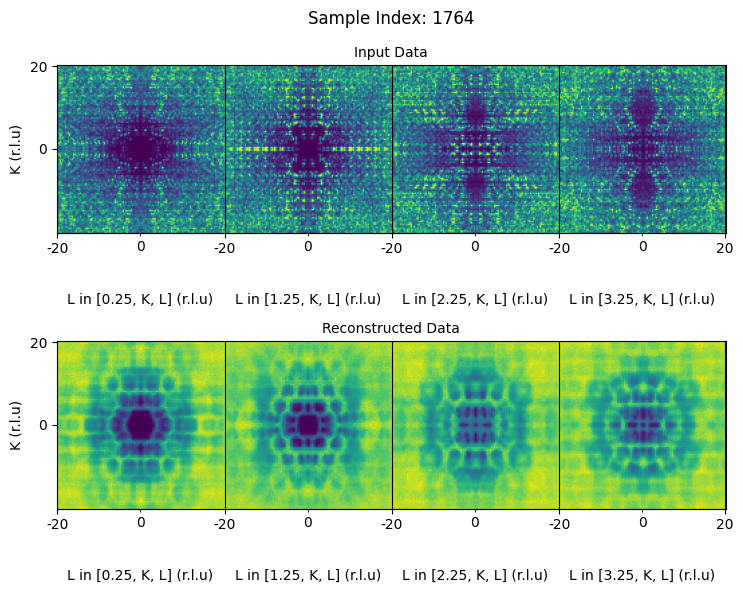

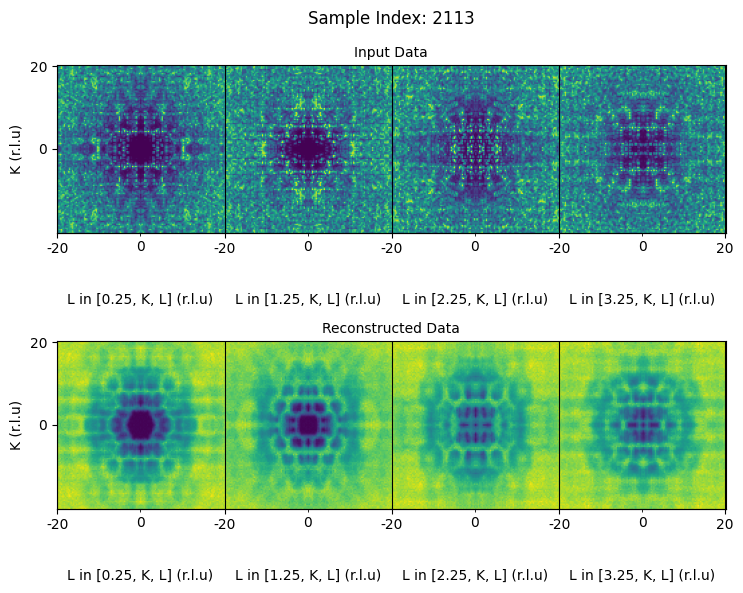

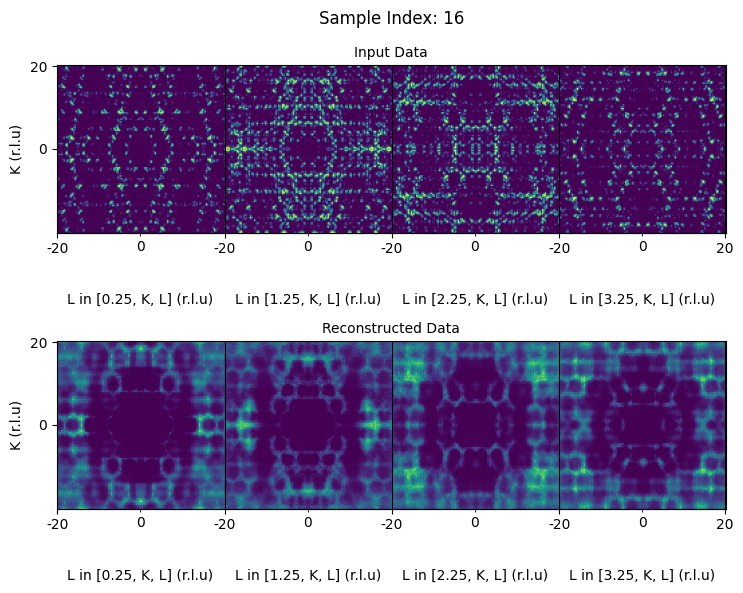

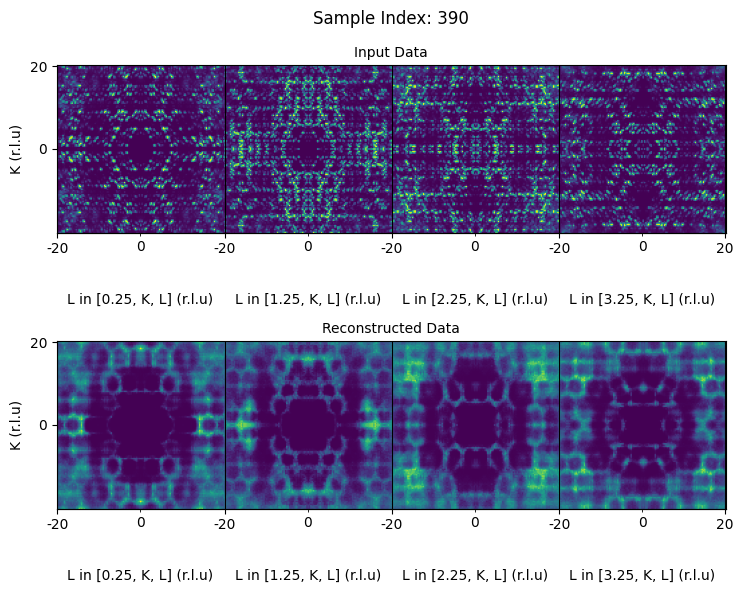

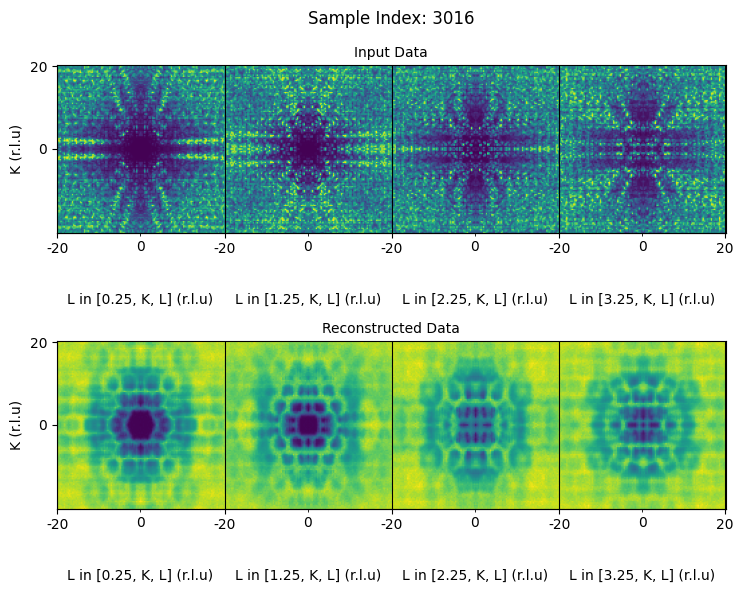

In [22]:
for i in range(5):
  displayRecon(np.random.randint(N_samples))

**Typical Dynamic Structure Factor For Different Phonon Modes**

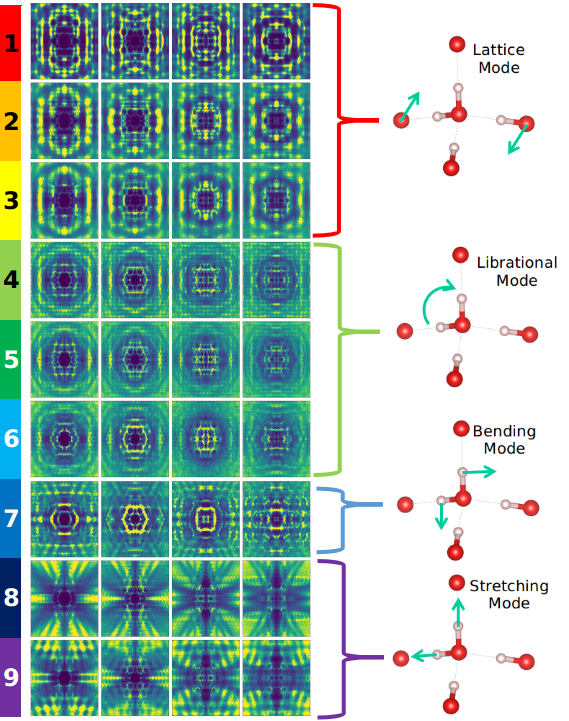

Define function to display latent space


In [23]:
# Define function to display latent space using PCA
from sklearn.decomposition import PCA
def displayPCA():
  coords0 = []
  modes0 = []
  displacements0 = []

  for x_input, disp, mode in data_all:
      mode = mode.detach().numpy()
      disp = disp.detach().numpy()
      for i in range(len(mode)):
          x_output, mu, logvar = autoencoder(x_input[i].to(device))
          # Collect coordinates for PCA
          coords0.append(mu.detach().to("cpu").numpy())
          modes0.append(mode[i])
          displacements0.append(disp[i])

  # Convert lists to numpy arrays
  coords = np.array(coords0)
  modes = np.array(modes0)
  displacements = np.array(displacements0)

  # Perform PCA
  pca = PCA(n_components=2)
  coords_pca = pca.fit_transform(coords)

  # Normalize to range [0, 8]
  displacements = (displacements / max(displacements) * 8).astype(int)
  cmap = plt.get_cmap("rainbow_r")

  # Create plots
  fig, (mode_plot, disp_plot) = plt.subplots(1, 2, figsize=(10, 3))

  sc_modes = mode_plot.scatter(coords_pca[:, 0], coords_pca[:, 1], s=2, c=modes, cmap=cmap)
  sc_disps = disp_plot.scatter(coords_pca[:, 0], coords_pca[:, 1], s=2, c=displacements, cmap=cmap)

  # Add colorbars
  cbar_modes = fig.colorbar(sc_modes, ax=mode_plot, ticks=np.arange(1, 10), boundaries=np.arange(0.5, 10.5, 1))
  cbar_disps = fig.colorbar(sc_disps, ax=disp_plot, ticks=np.arange(9), boundaries=np.arange(-0.5, 9.5, 1))
  cbar_modes.set_ticklabels(np.arange(1, 10))
  cbar_disps.set_ticklabels(['0 Å', '0.05 Å', '0.1 Å', '0.15 Å', '0.2 Å', '0.25 Å', '0.3 Å', '0.35 Å', '0.4 Å'])

  # Add labels
  mode_plot.set_xlabel("PC1")
  mode_plot.set_ylabel("PC2")
  disp_plot.set_xlabel("PC1")
  disp_plot.set_ylabel("PC2")

  fig.suptitle("Latent Space")
  mode_plot.set_title("Modes")
  disp_plot.set_title("Displacements")
  plt.show()
  return pca
# Define function to generate data from PCA
def generateFromPCA(pc12,pca):
    mu = pca.inverse_transform(pc12) # <-- expand back to dimensions of latent space
    mu = torch.tensor(mu,dtype=torch.float32).to(device)
    plt.figure(figsize=(22,12))
    recon=autoencoder.generate(mu)
    recon=recon.detach().to('cpu')
    recon=np.reshape(recon,((Ksize//kernel_size),(Lsize//kernel_size),4))
    datCombine=[]

    for idx in range(4):
      if idx==0:
        datCombine=reflect(recon[:,:,idx])
      else:
        datCombine=np.append(datCombine,reflect(recon[:,:,idx]),axis=0)
    plt.subplot(2,4,1)
    plt.imshow(datCombine.T)
    plt.title("PC1,PC2="+str(pc12))

    plt.axis("off")
    plt.tight_layout()

**Display latent space with principal components**

[Review on Principal Component Analysis (PCA) ](https://github.com/CAMM-UTK/acns-AI-tutorial/blob/main/Intro_Unsupervised_Learning/02_Autoencoders.ipynb)

The x-axis (**PC1**) and y-axis (**PC2**) represent the two principal components from PCA. They capture the most significant patterns of variance in the latent space, allowing us to visualize the primary trends and relationships between data points in two dimensions.

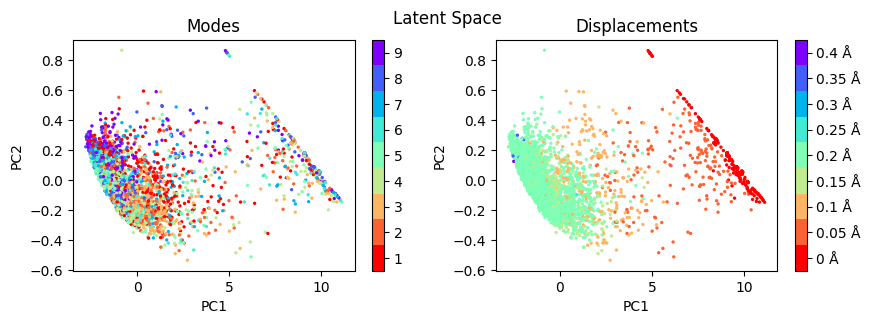

In [24]:
#Display latent space to PC1 and PC2
pca=displayPCA()

**Generate Data from Latent Space**

Pick your desired `[PC1, PC2]` coordinates from the above PCA plot of the latent space, and generate and visualize reconstructed data.

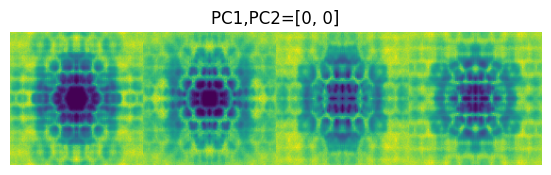

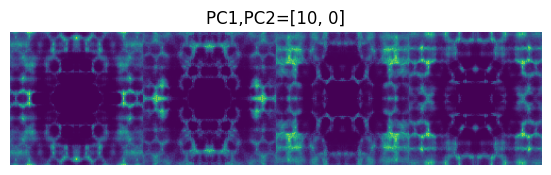

In [30]:
generateFromPCA([0,0],pca)
generateFromPCA([10,0],pca)

### **Optional: Hyperparameter Tuning with Grid Search**

This section is an optional tutorial that demonstrates how to perform hyperparameter tuning using a grid search approach. Here, we will test different hidden layer dimensions to evaluate their performance on the VAE model.

**Note:**
Hyperparameter tuning can be very time and resource-intensive.

[More info on grid search](https://www.w3schools.com/python/python_ml_grid_search.asp)

[More info on hyperparameter optimization](https://www.geeksforgeeks.org/hyperparameters-optimization-methods-ml/)


hidden dims:  [512, 128, 32]
Epoch:  0 Epoch:  1 Epoch:  2 Epoch:  3 
Loss:  101.40694427490234
CPU Time:  58.65693426132202
hidden dims:  [512, 128, 32, 8]
Epoch:  0 Epoch:  1 Epoch:  2 Epoch:  3 
Loss:  108.95325469970703
CPU Time:  39.88582396507263
hidden dims:  [256, 64, 16]
Epoch:  0 Epoch:  1 Epoch:  2 Epoch:  3 
Loss:  113.84056091308594
CPU Time:  26.427644968032837


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

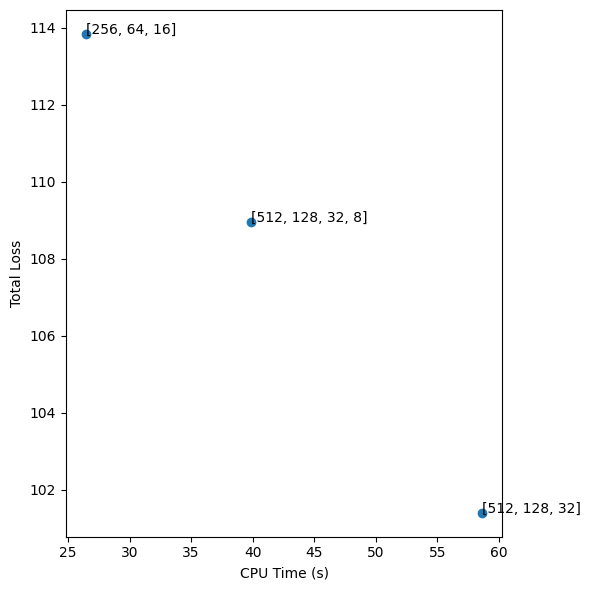

<Figure size 640x480 with 0 Axes>

In [26]:
# Grid search
# Example dimensions [256,128,32],[128,64,32], [512,128,64,16]
# Start large, get smaller
# Conventionally use powers of 2
# hidden_dims_params lists all the hidden dims to be evaluated
hidden_dims_params = [[512,128,32], [512,128,32,8], [256,64,16]]

# Experiment with these values too
epochs = 4
beta = 10.0
learning_rate = 10e-5

# Consider grid search libraries if you want to search more types of params
# https://scikit-learn.org/stable/modules/grid_search.html

# Also consider more efficient methods
# https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

# Note: hyperparameter tuning can quickly become very time/resource intensive,
# so be mindful and strategic about how you select parameters

final_loss = []
final_times = []

for idx, params in enumerate(hidden_dims_params):
  print("hidden dims: ", str(params))
  start_time = time.time()
  autoencoder = VAE(input_dims=[4,(Ksize//kernel_size),(Lsize//kernel_size)],hidden_dims=params,lat_dim=3)
  autoencoder=autoencoder.to(device)
  opt = torch.optim.Adam(autoencoder.parameters(),betas=(0.9,0.99))
  for i,param in enumerate(autoencoder.parameters()):
    if i >= 0:
        param.requires_grad=True
  for g in opt.param_groups:
    g['lr'] = learning_rate

  losses=np.empty((3,epochs))
  losses[:,1:]=np.nan
  np.set_printoptions(suppress=True)
  bestloss=1e10

  fig = plt.figure()

  for epoch in range(epochs):
    batchloss=torch.tensor(losses[:,0],dtype=torch.float32)
    for x_input, y, z in data_all:
        x_input = x_input[0].to(device)
        opt.zero_grad()
        x_output,mu,logvar = autoencoder(x_input)
        mse,kld=loss_fn(x_output, x_input, mu, logvar)
        kld*=beta
        loss=mse+kld
        batchloss+=torch.tensor([loss,mse,kld])
        loss=loss/x_input.shape[0]
        loss.backward()
        opt.step()

    losses[:,epoch]=(batchloss/len(data_all.dataset)).detach().to('cpu').numpy()
    print("Epoch: ", epoch, end=" ")
  final_loss.append(losses[:,epochs-1][0])
  final_times.append(time.time() - start_time)
  print("\nLoss: ", final_loss[-1])
  print("CPU Time: ", final_times[-1])
#print(final_loss)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(final_times, final_loss)
for i, dims in enumerate(hidden_dims_params):
    ax.annotate(str(dims), (final_times[i], final_loss[i]))
plt.xlabel("CPU Time (s)")
plt.ylabel("Total Loss")
plt.tight_layout()
plt.show()
plt.savefig(f"grid_search_results.png")

# Result of grid search is saved in temp files (folder icon on the left) as
# grid_search_results.png. Make sure to save to your local device or Drive
# or it will be lost when the session is restarted
